# IVP Tests: Linear and *Small-Amplitude* Nonlinear Evolution  
### *Diffusive Instability Numerical Stack — Verification & Demonstration Notebook*

This notebook provides an end-to-end demonstration of the **initial value problem (IVP)** capabilities of the `diffinst` codebase, **restricted entirely to the small-amplitude regime**.  
The purpose is to:

- validate that the **native nonlinear solver correctly reproduces linear theory** when perturbations remain small, and  
- verify consistency between EVP theory, linear time-domain evolution, and the early-time behaviour of the nonlinear solver.

We deliberately **do not** explore the fully nonlinear / large-amplitude regime here; that will be addressed in a separate notebook once stabilisation strategies are implemented.

Specifically, this notebook contains:

**1. Environment & project bootstrap**  
Automatic setup of the repository, editable installation, and loading of configs/utilities.

**2. Constructing eigenmode initial conditions**  
Using `scripts.make_ic_eigen`, we generate physically normalised eigenmode ICs at chosen `k_phys` and `Nx`.  
These ICs are essential for clean linear vs. nonlinear comparisons.

**3. Linear time-domain evolution (IMEX, native backend)**  
We evolve the linearised system from the exact eigenmode IC.  
We extract |Σ_k| over time and compare directly with the EVP growth rate γ.

**4. Nonlinear time-domain evolution (native backend, small amplitude)**  
Using the same small-amplitude IC, we run the nonlinear solver with perturbations still in the linear regime.  
We show that the nonlinear solver reproduces the linear growth rate and waveform evolution at early times.

**5. Resolution study (Nx = 128 vs 256)**  
We repeat the small-amplitude nonlinear run at higher resolution to demonstrate spectral convergence and resolution-independent growth rates.

**6. Field evolution snapshots**  
We visualise Σ(x,t) for linear and nonlinear runs, sampled across time, to inspect the waveform shape and linear growth.

**7. Diagnostics and metrics**  
We examine recorded metrics (mass, mode amplitudes) to confirm conservation properties and linear-regime behaviour.

**8. Alternative initial conditions (still small amplitude)**  
We test cosine and noise seeds with small amplitudes and show that they evolve according to linear theory (e.g. projection onto unstable eigenmodes).

**9. Dedalus backend verification (optional, memory-intensive)**  
A short Dedalus run at small amplitude (very small dt and short stop time) is compared against linear theory and the native solver.

---

Together, these sections demonstrate that:

- **EVP ↔ linear TD ↔ nonlinear (small amplitude)** all agree.  
- The native nonlinear solver is *correct in the linear regime*.  
- Resolution dependence behaves as expected.  
- Diagnostic quantities behave linearly.  
- Non-eigenmode ICs still grow for parameters permitting instability.  
- Dedalus and native backends match when both stay within the linear regime.

This notebook therefore acts as an **initial validation suite**, ensuring that all components of the time-domain stack reproduce **linear** diffusive-instability physics before attempting fully nonlinear saturation in a follow-up notebook.

## Minimal bootstrap: ensure correct project environment

Before running any tests, we perform a lightweight bootstrap to make sure:

- We correctly identify the project root (by searching upward for markers like `pyproject.toml`, `.git`, or `defaults.yaml`).
- The working directory is switched to the project root so that paths behave consistently.
- The `diffinst` package is installed in *editable* mode (`pip install -e`), ensuring that any code edits in the repository immediately propagate to the notebook environment without requiring reinstalls.

This block is intentionally self-contained and safe to run in any environment. It avoids assumptions about where the notebook is located and ensures reproducibility for future runs or collaborators.

In [76]:
# %% minimal bootstrap
import sys, os, subprocess, importlib.util
from pathlib import Path

def find_project_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(50):
        if any((p / m).exists() for m in ("pyproject.toml", ".git", "defaults.yaml")):
            return p
        if p == p.parent: break
        p = p.parent
    return start.resolve()

_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    spec = importlib.util.find_spec(pkg_name)
    need = (not spec) or (not getattr(spec, "origin", None)) or (Path(spec.origin).resolve().parents[0] != pkg_dir.resolve())
    if need:
        print(f"Installing {pkg_name} in editable mode from {pkg_dir} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(pkg_dir)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")

diffinst already installed from this repo.


## Imports & experiment paths

This block loads all core components needed for running IVP tests:

- **Numerical primitives**: NumPy for arrays, Matplotlib for plotting.
- **Project config**: `Config` for reading YAML experiment files.
- **Linear theory tools**: `evp_solve_at_k`, `evp_gamma` for eigenvalue/growth-rate comparisons.
- **Analysis API**: High-level helpers for loading manifests, checkpoints, metric streams, and reconstructed time series.

We also define shortcut paths for:
- a *stable* baseline experiment,
- an *unstable* baseline experiment,
- the project-wide defaults,
- the output run directory (`runs/`), created if missing.

This keeps the notebook clean: switching experiments only requires modifying two YAML files.

In [77]:
# %% imports & paths
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k
from diffinst.analysis_api import (
    load_manifest, load_config_from_run, list_checkpoints, load_metrics,
    load_linear_run, load_linear_Sigma_series, load_linear_amplitude,
    load_nonlinear_run, load_nonlinear_Sigma_series, load_nonlinear_amplitude,
    nearest_k_index, save_ic_npz, evp_gamma
)

EXP_STABLE   = ROOT / "experiments" / "baseline.yaml"
EXP_UNSTABLE = ROOT / "experiments" / "unstable_baseline.yaml"
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

print("project root:", ROOT)

project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


## Generating an initial condition from linear eigenmodes (Nx = 128)

Here we use the convenience script `scripts.make_ic_eigen` to generate an **eigenmode-aligned initial condition**:

- The YAML file `unstable_baseline.yaml` defines the physical parameters.
- `--k 100.0` selects the physical wavenumber at which to evaluate the EVP.
- The script extracts the *fastest-growing eigenvector* at that wavenumber and constructs a real-space perturbation.
- `--amp 1e-6` sets the physical amplitude: `max|Σ−Σ₀| = 10⁻⁶`.
- The result is saved as `runs/ic_k100_eigen.npz`, including arrays for Σ, vx, vy, uy.
- `--Nx 128` ensures the grid used for the IC matches the resolution we intend for the nonlinear run.

This IC file can be directly passed to both the **native nonlinear solver** and the **Dedalus backend**, guaranteeing that their initial states are identical and comparable to linear theory.

In [78]:
# IC at Nx = 128
! python -m scripts.make_ic_eigen \
  --config experiments/unstable_baseline.yaml \
  --out runs/ic_k100_eigen.npz \
  --k 100.0 \
  --amp 1e-6 \
  --Nx 128 \
  --exact-fit-harm 2 

[make_ic_eigen] IC written to runs/ic_k100_eigen.npz (k=100.0, amp=1e-06, Nx=128)


## Linear time-domain evolution from the EVP-based initial condition

We now evolve the exact same eigenmode-constructed IC using the **native linear IMEX solver**.

Key points:

- `--init-from runs/ic_k100_eigen.npz` ensures *bitwise-identical* initial fields between the linear and nonlinear comparisons.
- Since the eigenmode is a pure sinusoid of a single k, linear theory predicts:
  \[
  \Sigma(x, t) = \Sigma_0 + A_0\, e^{\gamma t} \cos(kx)
  \]
  with γ taken from the EVP (`evp_gamma`).
- The chosen time step `dt = 1e-3` is safely below the stability threshold for the linear IMEX scheme.
- `--save-stride 200` provides a manageable number of checkpoints for later amplitude extraction.
- This run writes both checkpoint snapshots and a `metrics.jsonl` file containing the measured mode-1 amplitude.

The purpose of this block is to establish a **ground-truth reference curve** for exponential growth, which we will compare directly with the nonlinear evolution later in the notebook.

In [79]:
# %% run linear TD from that exact IC (CLI)
! python -m scripts.run_linear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/lin_from_ic \
  --mode linear \
  --dt 1e-3 \
  --stop_time 10 \
  --save-stride 200 \
  --init-from runs/ic_k100_eigen.npz

[linear] done: {'t_final': 10.0, 'steps': 10001, 'Nx': 128, 'Lx': 0.12566370614359174}


## Nonlinear time-domain evolution from the same exact IC

We now repeat the experiment, but using the **full nonlinear pseudo-spectral solver**.

Important points:

- The initial condition is *identical* to the linear case (`--init-from runs/ic_k100_eigen.npz`).
- This run uses the native nonlinear IMEX integrator with:
  - Explicit advection, variable-coefficient diffusion, and nonlinear fluxes.
  - Implicit viscosity/drag terms using frozen-coefficient Laplacians.
- Because the amplitude is extremely small (`1e−6`), the **early-time evolution should match the linear prediction** to machine precision.
  - Deviations only arise once nonlinear corrections become comparable to the linear forcing terms.
- We keep `dt = 1e−3` and `Nx = 128` to match the linear run exactly.
- `--print-stride 400` prints solver progress every 400 steps without excessive notebook spam.
- `--save-stride 200` ensures matched sampling cadence with the linear run for direct amplitude comparison.

This run establishes the **nonlinear growth curve**, which we will overlay with the EVP growth rate and the linear IMEX curve in the analysis section below.

In [80]:
# %% run nonlinear TD from that exact IC (CLI)
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_from_ic \
  --mode nonlinear \
  --dt 1e-3 \
  --stop_time 10 \
  --save-stride 200 \
  --init-from runs/ic_k100_eigen.npz \
  --Nx 128 \
  --print-stride 400 \
  --force

[INFO] Removing existing output directory: runs/nl_from_ic
2025-11-20 16:50:05,481 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=400  t=4.000000e-01  dt=1.000e-03
2025-11-20 16:50:05,883 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=800  t=8.000000e-01  dt=1.000e-03
2025-11-20 16:50:06,279 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=1200  t=1.200000e+00  dt=1.000e-03
2025-11-20 16:50:06,676 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=1600  t=1.600000e+00  dt=1.000e-03
2025-11-20 16:50:07,073 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=2000  t=2.000000e+00  dt=1.000e-03
2025-11-20 16:50:07,470 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=2400  t=2.400000e+00  dt=1.000e-03
2025-11-20 16:50:07,864 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=2800  t=2.800000e+00  dt=1.000e-03
2025-11-20 16:50:08,260 diffinst.solvers.native_nonlinear INFO :: Native nonlinear

## Resolution check: nonlinear run at higher grid resolution (Nx = 256)

To test the **numerical convergence** of the nonlinear solver, we now repeat the unstable-eigenmode experiment at **double the spatial resolution**:

- First, we regenerate the *same physical eigenmode* initial condition, but sampled on a grid with `Nx = 256`.  
  - The scripts recompute the EVP at the same physical wavenumber `k = 100`, then construct the mode on the finer grid.
  - The physical amplitude is again `amp = 1e−6`, so this is a clean *small-perturbation* test.

- Next, we run the **native nonlinear solver** with:
  - `Nx = 256`, `dt = 1e−3`, `stop_time = 5`, `save_stride = 200`
  - `--init-from` pointing to the new `Nx = 256` IC file.

Because the physics and parameters are identical and only the resolution has changed, we can:

- Compare **mode amplitudes vs. time** between:
  - Linear IMEX @ Nx = 128
  - Nonlinear native @ Nx = 128
  - Nonlinear native @ Nx = 256
- Check **resolution independence** of:
  - The early-time growth rate (should match EVP).
  - The overall shape of the growth curve, at least while amplitudes remain small.

These runs will be used below to verify that the **nonlinear solver is converged in Nx** in the small-amplitude regime.

In [81]:
# IC at Nx = 256
! python -m scripts.make_ic_eigen \
  --config experiments/unstable_baseline.yaml \
  --out runs/ic_k100_eigen_Nx256.npz \
  --k 100.0 \
  --amp 1e-6 \
  --Nx 256 \
  --exact-fit-harm 2

[make_ic_eigen] IC written to runs/ic_k100_eigen_Nx256.npz (k=100.0, amp=1e-06, Nx=256)


In [82]:
# Nonlinear native, Nx=256, using that IC
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_from_ic_Nx256 \
  --backend native \
  --mode nonlinear \
  --Nx 256 \
  --dt 1e-3 \
  --stop_time 10 \
  --save-stride 200 \
  --init-from runs/ic_k100_eigen_Nx256.npz \
  --force

[INFO] Removing existing output directory: runs/nl_from_ic_Nx256
[nonlinear] done: {'t_final': 10.0, 'steps': 10001, 'Nx': 256, 'Lx': 0.12566370614359174}


## Comparing linear theory and nonlinear time–domain evolution (resolution check)

We now compare the **mode amplitude growth** for three runs that all start from the *same physical eigenmode* at wavenumber `k = 100`:

- **Linear IMEX (Nx = 128)**, initialized from the saved eigenmode IC.
- **Nonlinear native (Nx = 128)**, initialized from that *same* IC.
- **Nonlinear native (Nx = 256)**, initialized from a recomputed IC at higher resolution.

For each run we:

1. Load the series Σ(x, t) from the checkpoints.
2. Extract the **physical cosine amplitude** of the target mode at `k = 100` using the analysis helpers.
3. Plot |Σₖ|(t) on a log scale and overlay the **EVP prediction**  
   \[
   |Σₖ(t)| \propto e^{\gamma (t - t_0)}
   \]
   with γ taken from the EVP solver.

The goals of this plot are:

- To show that in the **small-amplitude regime**:
  - Linear time-domain evolution matches the EVP growth rate.
  - Nonlinear native evolution tracks the same exponential curve until nonlinear effects become important.
- To verify that the nonlinear curve is **resolution-independent**:
  - The Nx = 256 run is re-normalized so that its initial |Σₖ| matches the Nx = 128 run.
  - After this re-normalization, the *shape* and *growth rate* of |Σₖ|(t) should overlay tightly between the two resolutions.

This provides an end-to-end sanity check that:
- The eigenmode IC is wired correctly into both the linear and nonlinear solvers.
- The nonlinear native solver reproduces the linear growth rate for small amplitudes.
- The solver behaves consistently under refinement of Nx (at least in the linear/small-amplitude regime).

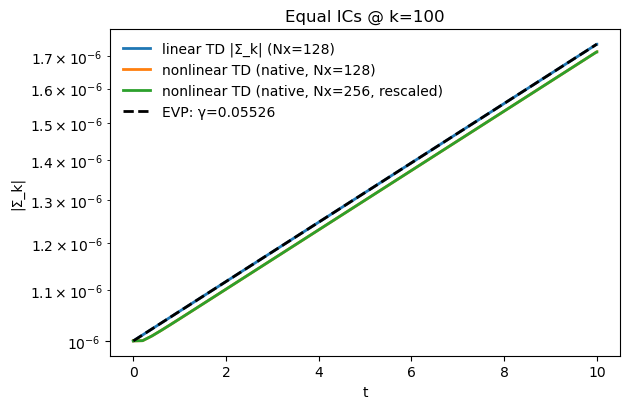

In [83]:
k_phys = 100

# %% load amplitude vs time for linear and nonlinear (native, Nx=128 and Nx=256)
RUN_L      = RUNS / "lin_from_ic"
RUN_N      = RUNS / "nl_from_ic"             # native, Nx = 128
RUN_N_256  = RUNS / "nl_from_ic_Nx256"       # native, Nx = 256

TL, AL       = load_linear_amplitude(RUN_L, k_phys)
TN, AN       = load_nonlinear_amplitude(RUN_N, k_phys)
TN_256, AN_256 = load_nonlinear_amplitude(RUN_N_256, k_phys)

cfgL  = load_config_from_run(RUN_L)
gamma = evp_gamma(cfgL, k_phys)
A0    = AL[0]

# Normalize Nx=256 amplitude so that its initial value matches the Nx=128 nonlinear run
A0_128  = AN[0]
A0_256  = AN_256[0]
scale_256 = A0_128 / A0_256 if A0_256 != 0.0 else 1.0

fig, ax = plt.subplots(figsize=(6.4, 4.2))
ax.plot(TL, AL, lw=2, label="linear TD |Σ_k| (Nx=128)")
ax.plot(TN, AN, lw=2, label="nonlinear TD (native, Nx=128)")
ax.plot(TN_256, AN_256 * scale_256, lw=2, label="nonlinear TD (native, Nx=256, rescaled)")
ax.plot(TL, A0 * np.exp(gamma * (TL - TL[0])), "k--", lw=2, label=f"EVP: γ={gamma:.4g}")

ax.set_yscale("log")
ax.set_xlabel("t")
ax.set_ylabel("|Σ_k|")
ax.legend(frameon=False)
ax.set_title(f"Equal ICs @ k={k_phys}")
plt.tight_layout()
plt.show()

## Spatial snapshots: linear vs nonlinear evolution (different resolutions)

To complement the **mode-amplitude** comparison, it’s useful to look directly at the
**real-space profiles** Σ(x, t) from:

1. The **linear time–domain** run (Nx = 128),
2. The **nonlinear native** run (Nx = 128),
3. The **nonlinear native** run at **higher resolution** (Nx = 256).

In the figure below:

- Each column shows Σ(x, t) for one of the three runs.
- Within each panel, several snapshots are taken from **early → late times**, and
  are color-coded using a continuous colormap so that the time ordering is visually
  obvious (e.g. light → dark or blue → yellow).
- All three panels share the same y-axis (Σ), which makes it easier to see how the
  nonlinear profiles depart from the linear eigenmode shape as the instability grows,
  and how the Nx = 256 run compares visually to the Nx = 128 nonlinear run.

This gives an immediate, qualitative sanity check:
- Early times: all three panels look nearly identical.
- Later times: nonlinear structure emerges, and the two nonlinear runs agree well
  despite the different grid resolution.

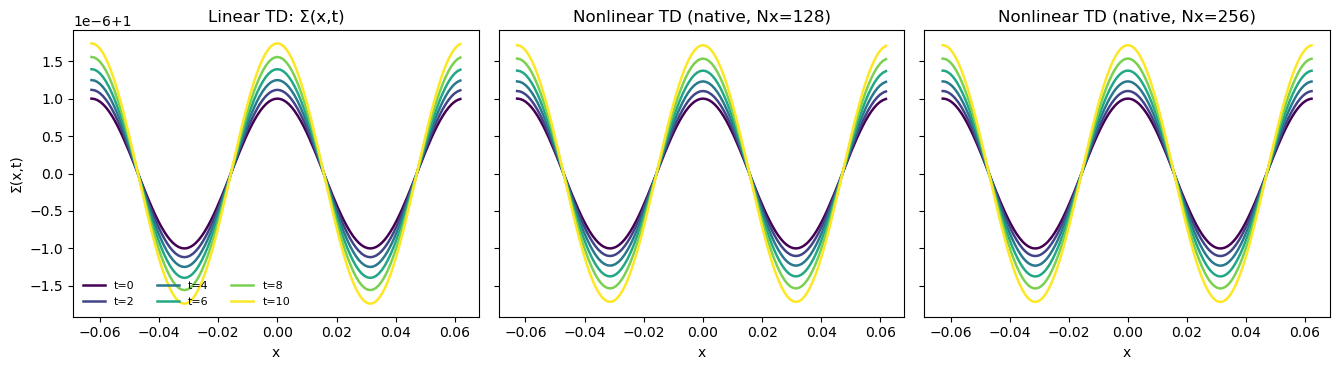

In [84]:
# %% Σ(x, t) snapshots for linear and nonlinear runs (Nx=128 and Nx=256) in one figure

# --- load linear run ---
NxL, LxL, filesL, *_ = load_linear_run(RUN_L)
cfgL = load_config_from_run(RUN_L)
S0L = cfgL.sig_0
TLs, SigL = load_linear_Sigma_series(filesL, NxL, S0L)

# --- load nonlinear native Nx=128 ---
NxN, LxN, filesN, _ = load_nonlinear_run(RUN_N)
TNs, SigN = load_nonlinear_Sigma_series(filesN)

# --- load nonlinear native Nx=256 ---
NxN256, LxN256, filesN256, _ = load_nonlinear_run(RUN_N_256)
TNs256, SigN256 = load_nonlinear_Sigma_series(filesN256)

# physical grids
xL    = np.linspace(-0.5 * LxL,    0.5 * LxL,    NxL,    endpoint=False)
xN    = np.linspace(-0.5 * LxN,    0.5 * LxN,    NxN,    endpoint=False)
xN256 = np.linspace(-0.5 * LxN256, 0.5 * LxN256, NxN256, endpoint=False)

# helper: plot snapshots with a colormap encoding time
def plot_snapshots_panel(ax, x, T, Sig, title, nsamp=6):
    idxs = np.linspace(0, len(T) - 1, nsamp, dtype=int)
    cmap = plt.get_cmap("viridis")

    for j, i in enumerate(idxs):
        frac = j / max(nsamp - 1, 1)
        ax.plot(x, Sig[i], lw=1.8, color=cmap(frac), label=f"t={T[i]:.3g}")

    ax.set_xlabel("x")
    ax.set_title(title)

# make figure with three panels: linear, nonlinear Nx=128, nonlinear Nx=256
fig, axes = plt.subplots(1, 3, figsize=(13.5, 3.8), sharey=True)

plot_snapshots_panel(axes[0], xL,    TLs,    SigL,    "Linear TD: Σ(x,t)")
plot_snapshots_panel(axes[1], xN,    TNs,    SigN,    "Nonlinear TD (native, Nx=128)")
plot_snapshots_panel(axes[2], xN256, TNs256, SigN256, "Nonlinear TD (native, Nx=256)")

axes[0].set_ylabel("Σ(x,t)")

# put a legend only on the first axis to avoid clutter
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    axes[0].legend(handles, labels, ncol=3, fontsize=8, frameon=False)

plt.tight_layout()
plt.show()

## Basic diagnostics from the nonlinear IVP run

The nonlinear solver writes a small set of time–series diagnostics to `metrics.jsonl` in each run directory.  
For the current native nonlinear run, we typically track:

- `mass`: the domain-averaged surface density ⟨Σ⟩(t), which should be nearly conserved.
- `mode1_amp`: the physical amplitude of the first nonzero Fourier mode of Σ, which is a simple proxy for the growth of structure.

Below, we load the metrics from the native nonlinear run and plot **each metric in its own subplot** against time. This gives a quick sanity check that:

- the mass stays constant to good accuracy, and  
- the mode amplitude grows (and eventually deviates from the linear prediction) in the expected way.

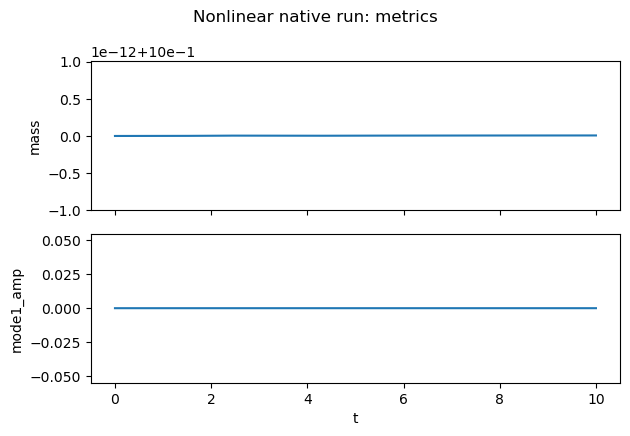

In [75]:
# %% inspect tracked metrics for the native nonlinear run
tM_N, colsN = load_metrics(RUN_N)

import numpy as np
import matplotlib.pyplot as plt

def plot_nonlinear_metrics(t, cols, title="Nonlinear metrics"):
    """Plot each metric column vs time in its own subplot."""
    if t is None or np.size(t) == 0 or not cols:
        print(f"{title}: no metrics found.")
        return

    keys = sorted(cols.keys())
    n = len(keys)
    if n == 0:
        print(f"{title}: nothing plottable.")
        return

    fig, axes = plt.subplots(
        n, 1, sharex=True,
        figsize=(6.4, 2.2 * n),
    )
    if n == 1:
        axes = [axes]

    for ax, k in zip(axes, keys):
        a = np.asarray(cols[k]).squeeze()
        if a.size == 0:
            continue
        if a.size == 1:
            # scalar / length-1 → draw horizontal line
            ax.plot(t, np.full_like(t, float(a), dtype=float), linestyle="--")
        else:
            m = min(len(t), len(a))
            ax.plot(t[:m], a[:m])
        ax.set_ylabel(k)

    axes[-1].set_xlabel("t")
    fig.suptitle(title, y=0.98)
    plt.tight_layout()
    plt.show()

plot_nonlinear_metrics(tM_N, colsN, title="Nonlinear native run: metrics")

## Nonlinear IVP with small-amplitude random noise IC

So far we seeded the system with a single unstable eigenmode at fixed wavenumber \(k = 100\).  
Here we switch to a **random noise initial condition** to check that:

- the code behaves sensibly for a broadband perturbation, and  
- in the small-amplitude regime, the early-time growth is still consistent with linear expectations (the unstable band gets amplified out of the initial white noise).

This run uses:

- `seed_mode = noise`: draws Σ fluctuations from a Gaussian with zero mean,  
- `amp = 1e-2` in *physical* units (via `--amp-physical`), so the IC is still firmly in the linear regime,  
- a fixed RNG seed (`--seed 42`) for reproducibility.

We keep all other parameters (box, physics, timestep, etc.) identical to the eigenmode tests above.

In [49]:
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_noise_native \
  --backend native \
  --mode nonlinear \
  --dt 1e-3 \
  --stop_time 5 \
  --save-stride 200 \
  --seed-mode noise \
  --amp 1e-2 \
  --amp-physical \
  --seed 42 \
  --print-stride 300 \
  --force

[INFO] Removing existing output directory: runs/nl_noise_native
2025-11-20 16:31:57,790 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=300  t=3.000000e-01  dt=1.000e-03
2025-11-20 16:31:58,081 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=600  t=6.000000e-01  dt=1.000e-03
2025-11-20 16:31:58,397 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=900  t=9.000000e-01  dt=1.000e-03
2025-11-20 16:31:58,693 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=1200  t=1.200000e+00  dt=1.000e-03
2025-11-20 16:31:59,019 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=1500  t=1.500000e+00  dt=1.000e-03
2025-11-20 16:31:59,324 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=1800  t=1.800000e+00  dt=1.000e-03
2025-11-20 16:31:59,616 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=2100  t=2.100000e+00  dt=1.000e-03
2025-11-20 16:31:59,900 diffinst.solvers.native_nonlinear INFO :: Native nonli

### Diagnostics for the noise-seeded nonlinear run

We now inspect the nonlinear evolution from the **noise-seeded run**:

- **Top-left:** snapshots of Σ(x, t) at a few representative times, showing how initially white noise develops coherent structure.
- **Top-right:** evolution of the maximum surface density, maxₓ Σ(x, t) − Σ₀, as a simple scalar measure of nonlinearity.
- **Bottom-left:** tracked diagnostics from the solver:
  - total mass ⟨Σ⟩(t),
  - fundamental Fourier mode amplitude `mode1_amp`(t).
- **Bottom-right:** root-mean-square x-velocity, vₓ,rms(t), as a measure of how kinetic energy grows from the initial noise.

This gives a compact view of how the system evolves in space, in Fourier space, and in a few low-dimensional diagnostics.

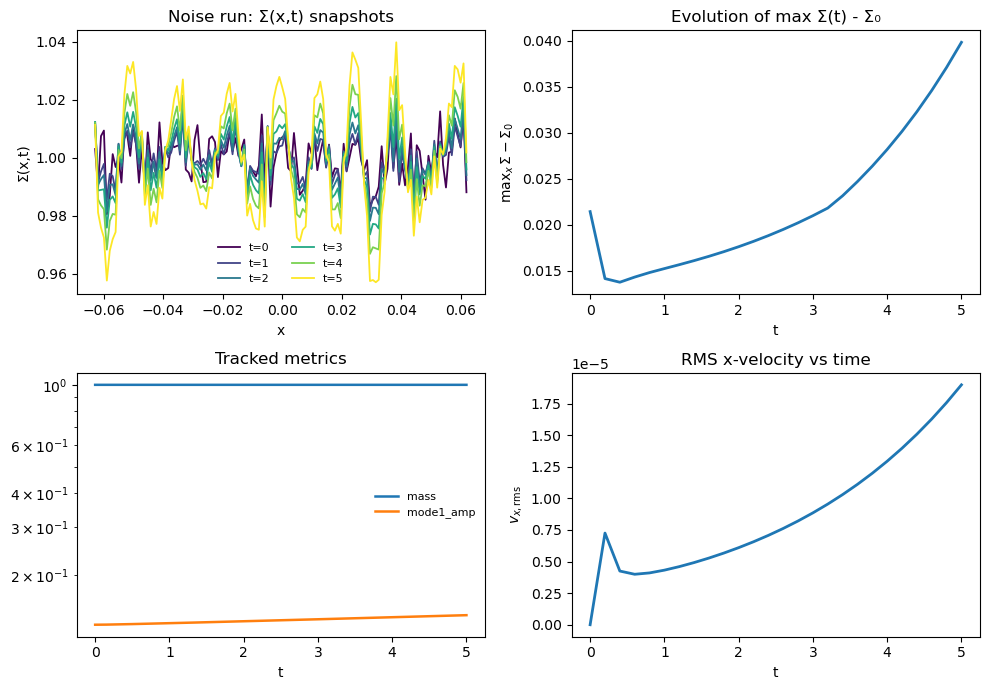

In [50]:
# %% diagnostics for the noise-seeded nonlinear run

RUN_NOISE = RUNS / "nl_noise_native"

# Load nonlinear density evolution
Nx, Lx, files, man = load_nonlinear_run(RUN_NOISE)
T, Sig = load_nonlinear_Sigma_series(files)   # T: (Nt,), Sig: (Nt, Nx)

# Physical grid
x = np.linspace(-0.5*Lx, 0.5*Lx, Nx, endpoint=False)

# Background Σ0 from config
cfg_noise = load_config_from_run(RUN_NOISE)
S0_noise = float(getattr(cfg_noise, "S0", getattr(cfg_noise, "sig_0", 1.0)))

# --- 1) Pick a few snapshots for Σ(x,t) ---
nsamp = 6
idxs = np.linspace(0, len(T) - 1, nsamp, dtype=int)

# --- 2) Time evolution of max Σ - Σ0 ---
Sig_max = Sig.max(axis=1)
Sig_max_minus = Sig_max - S0_noise

# --- 3) Solver metrics: mass, mode1_amp ---
tM, cols = load_metrics(RUN_NOISE)
mass = cols.get("mass", None)
mode1 = cols.get("mode1_amp", None)

# --- 4) vx_rms(t): need vx from checkpoints ---
vx_series = []
for fn in files:
    with np.load(fn) as Z:
        vx_series.append(np.asarray(Z["vx"]))
vx_series = np.array(vx_series)     # (Nt, Nx)
vx_rms = np.sqrt(np.mean(vx_series**2, axis=1))

# --- Plot: 2x2 panel with all diagnostics ---
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
(ax_snap, ax_max), (ax_metrics, ax_vx) = axes

# (a) Σ snapshots
cmap = plt.get_cmap("viridis")
for j, i in enumerate(idxs):
    frac = j / max(nsamp - 1, 1)
    ax_snap.plot(x, Sig[i], lw=1.3, color=cmap(frac), label=f"t={T[i]:.3g}")
ax_snap.set_xlabel("x")
ax_snap.set_ylabel("Σ(x,t)")
ax_snap.set_title("Noise run: Σ(x,t) snapshots")
ax_snap.legend(ncol=2, fontsize=8, frameon=False)

# (b) max Σ - Σ0 vs time
ax_max.plot(T, Sig_max_minus, lw=2)
ax_max.set_xlabel("t")
ax_max.set_ylabel(r"max$_x\,\Sigma - \Sigma_0$")
ax_max.set_title("Evolution of max Σ(t) - Σ₀")

# (c) metrics: mass and mode1_amp
if mass is not None:
    n = min(len(tM), len(mass))
    ax_metrics.plot(tM[:n], mass[:n], lw=1.8, label="mass")
if mode1 is not None:
    n = min(len(tM), len(mode1))
    ax_metrics.plot(tM[:n], mode1[:n], lw=1.8, label="mode1_amp")
ax_metrics.set_xlabel("t")
ax_metrics.set_title("Tracked metrics")
ax_metrics.legend(frameon=False, fontsize=8)
ax_metrics.set(yscale = "log")

# (d) vx_rms(t)
ax_vx.plot(T, vx_rms, lw=2)
ax_vx.set_xlabel("t")
ax_vx.set_ylabel(r"$v_{x,\mathrm{rms}}$")
ax_vx.set_title("RMS x-velocity vs time")

plt.tight_layout()
plt.show()

### Diagnostics for a cosine-seeded nonlinear run

We now repeat the same diagnostics for a **cosine initial condition**:

- **Top-left:** Σ(x, t) snapshots at a few times, starting from a single sinusoidal mode.
- **Top-right:** evolution of the peak surface density, maxₓ Σ(x, t) − Σ₀.
- **Bottom-left:** solver-tracked metrics (mass and fundamental mode amplitude).
- **Bottom-right:** root-mean-square x-velocity, vₓ,rms(t).

Comparing this panel to the noise-seeded case highlights how the system evolves when we seed a single coherent mode instead of broadband noise.

In [37]:
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_cos_native \
  --backend native \
  --mode nonlinear \
  --dt 1e-3 \
  --stop_time 5 \
  --save-stride 200 \
  --seed-mode cos \
  --amp 1e-2 \
  --amp-physical \
  --seed 42 \
  --force

[INFO] Removing existing output directory: runs/nl_cos_native
[nonlinear] done: {'t_final': 5.0, 'steps': 5000, 'Nx': 128, 'Lx': 0.12566370614359174}


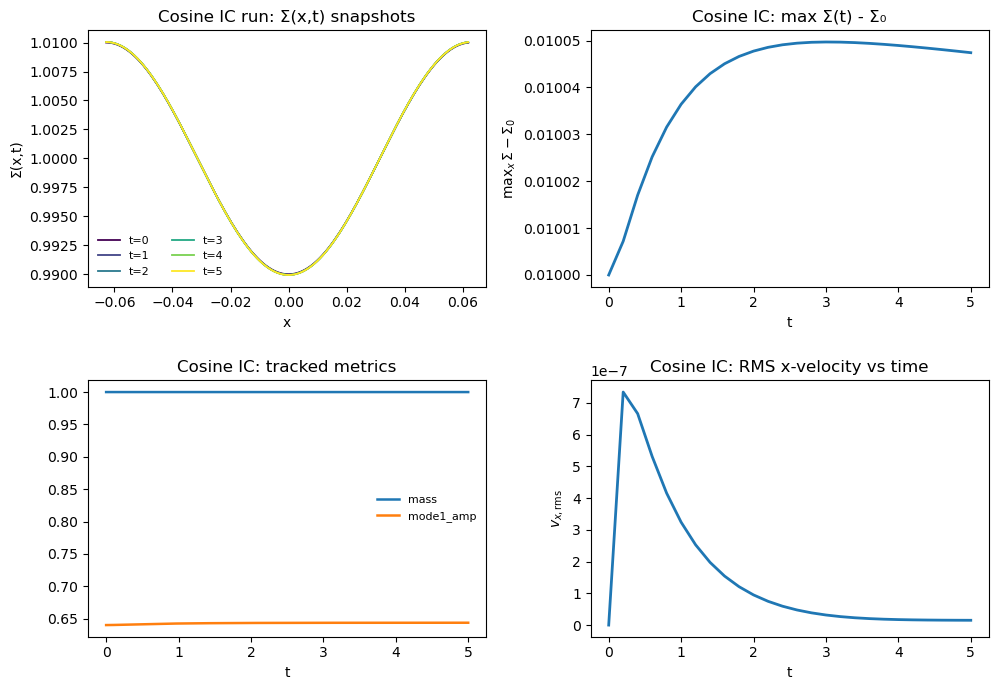

In [38]:
# %% diagnostics for the cosine-seeded nonlinear run

RUN_COS = RUNS / "nl_cos_native"   # assumes you've run a cosine-seeded native NL run into this dir

# Load nonlinear density evolution
Nx_c, Lx_c, files_c, man_c = load_nonlinear_run(RUN_COS)
T_c, Sig_c = load_nonlinear_Sigma_series(files_c)   # T_c: (Nt,), Sig_c: (Nt, Nx_c)

# Physical grid
x_c = np.linspace(-0.5*Lx_c, 0.5*Lx_c, Nx_c, endpoint=False)

# Background Σ0 from config
cfg_cos = load_config_from_run(RUN_COS)
S0_cos = float(getattr(cfg_cos, "S0", getattr(cfg_cos, "sig_0", 1.0)))

# --- 1) Pick a few snapshots for Σ(x,t) ---
nsamp = 6
idxs_c = np.linspace(0, len(T_c) - 1, nsamp, dtype=int)

# --- 2) Time evolution of max Σ - Σ0 ---
Sig_max_c = Sig_c.max(axis=1)
Sig_max_minus_c = Sig_max_c - S0_cos

# --- 3) Solver metrics: mass, mode1_amp ---
tM_c, cols_c = load_metrics(RUN_COS)
mass_c = cols_c.get("mass", None)
mode1_c = cols_c.get("mode1_amp", None)

# --- 4) vx_rms(t): need vx from checkpoints ---
vx_series_c = []
for fn in files_c:
    with np.load(fn) as Z:
        vx_series_c.append(np.asarray(Z["vx"]))
vx_series_c = np.array(vx_series_c)     # (Nt, Nx_c)
vx_rms_c = np.sqrt(np.mean(vx_series_c**2, axis=1))

# --- Plot: 2x2 panel with all diagnostics for cosine IC ---
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
(ax_snap_c, ax_max_c), (ax_metrics_c, ax_vx_c) = axes

# (a) Σ snapshots
cmap = plt.get_cmap("viridis")
for j, i in enumerate(idxs_c):
    frac = j / max(nsamp - 1, 1)
    ax_snap_c.plot(x_c, Sig_c[i], lw=1.3, color=cmap(frac), label=f"t={T_c[i]:.3g}")
ax_snap_c.set_xlabel("x")
ax_snap_c.set_ylabel("Σ(x,t)")
ax_snap_c.set_title("Cosine IC run: Σ(x,t) snapshots")
ax_snap_c.legend(ncol=2, fontsize=8, frameon=False)

# (b) max Σ - Σ0 vs time
ax_max_c.plot(T_c, Sig_max_minus_c, lw=2)
ax_max_c.set_xlabel("t")
ax_max_c.set_ylabel(r"max$_x\,\Sigma - \Sigma_0$")
ax_max_c.set_title("Cosine IC: max Σ(t) - Σ₀")

# (c) metrics: mass and mode1_amp
if mass_c is not None:
    n = min(len(tM_c), len(mass_c))
    ax_metrics_c.plot(tM_c[:n], mass_c[:n], lw=1.8, label="mass")
if mode1_c is not None:
    n = min(len(tM_c), len(mode1_c))
    ax_metrics_c.plot(tM_c[:n], mode1_c[:n], lw=1.8, label="mode1_amp")
ax_metrics_c.set_xlabel("t")
ax_metrics_c.set_title("Cosine IC: tracked metrics")
ax_metrics_c.legend(frameon=False, fontsize=8)

# (d) vx_rms(t)
ax_vx_c.plot(T_c, vx_rms_c, lw=2)
ax_vx_c.set_xlabel("t")
ax_vx_c.set_ylabel(r"$v_{x,\mathrm{rms}}$")
ax_vx_c.set_title("Cosine IC: RMS x-velocity vs time")

plt.tight_layout()
plt.show()

### Dedalus backend sanity check (short run)

As a final sanity check in the **small-amplitude regime**, we also run the same eigenmode initial condition through the **Dedalus backend**:

#### Warning!
The Dedalus backend is much more CPU- and memory-intensive than the native pseudo-spectral solver. Even for this short run (t = 0.5 with dt = 2×10⁻⁴), you may see high CPU usage, more logging, and larger checkpoint files. For convergence tests and production runs, you’ll typically rely on the native backend and use Dedalus only as an independent cross-check.

Below we compare the measured growth rates from:
- EVP (eigenvalue problem, “ground truth” γ),
- Linear time-domain solver (lin_from_ic),
- Native nonlinear solver (nl_from_ic, Nx=128),
- Native nonlinear solver (nl_from_ic_Nx256, Nx=256),
- Dedalus nonlinear solver (nl_from_ic_dedalus).

We fit γ from each run via a linear regression of log |Σₖ| vs t over an early-time window where the evolution is still linear.

In [31]:
! python -m scripts.run_nonlinear \
  --config experiments/unstable_baseline.yaml \
  --outdir runs/nl_from_ic_dedalus \
  --backend dedalus \
  --mode nonlinear --dt 2e-4 --stop_time 1 --save-stride 200 --print-stride 200\
  --init-from runs/ic_k100_eigen.npz

2025-11-13 16:24:41,841 h5py._conv DEBUG :: Creating converter from 7 to 5
2025-11-13 16:24:41,842 h5py._conv DEBUG :: Creating converter from 5 to 7
2025-11-13 16:24:41,842 h5py._conv DEBUG :: Creating converter from 7 to 5
2025-11-13 16:24:41,842 h5py._conv DEBUG :: Creating converter from 5 to 7
2025-11-13 16:24:42,571 distributor DEBUG :: Mesh: []
2025-11-13 16:24:42,577 transforms DEBUG :: Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (2, 128, 1), 1)
2025-11-13 16:24:42,696 problems DEBUG :: Adding equation 0
2025-11-13 16:24:42,697 problems DEBUG ::   LHS: dt(sig)
2025-11-13 16:24:42,697 problems DEBUG ::   RHS: -1*dx(v@ex*sig)
2025-11-13 16:24:42,697 problems DEBUG ::   condition: True
2025-11-13 16:24:42,697 problems DEBUG ::   M: sig
2025-11-13 16:24:42,698 problems DEBUG ::   L: 0
2025-11-13 16:24:42,698 problems DEBUG ::   F: -1*dx(v@ex*sig)
2025-11-13 16:24:42,698 problems DEBUG :: Adding equation 1
2025-11-13 16:24:42,698 problems DEBUG ::   

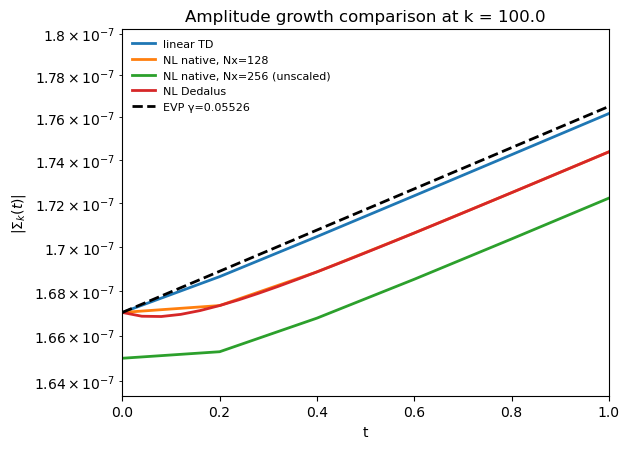

In [33]:
# %% single-panel plot: EVP vs linear TD vs native NL vs Dedalus NL
k_phys = 100.0

RUN_L       = RUNS / "lin_from_ic"
RUN_N       = RUNS / "nl_from_ic"          
RUN_N_256   = RUNS / "nl_from_ic_Nx256"    
RUN_D       = RUNS / "nl_from_ic_dedalus"  

# Load amplitudes
TL, AL         = load_linear_amplitude(RUN_L, k_phys)
TN, AN         = load_nonlinear_amplitude(RUN_N, k_phys)
TN_256, AN_256 = load_nonlinear_amplitude(RUN_N_256, k_phys)
TD, AD         = load_nonlinear_amplitude(RUN_D, k_phys)

# EVP reference growth rate
cfgL        = load_config_from_run(RUN_L)
gamma_evp   = evp_gamma(cfgL, k_phys)
A0          = AL[0]


# EVP reference curve
A_evp = A0 * np.exp(gamma_evp * (TL - TL[0]))

# --- plot ---
fig, ax = plt.subplots(figsize=(6.4, 4.6))

ax.plot(TL,      AL,        lw=2, label="linear TD")
ax.plot(TN,      AN,        lw=2, label="NL native, Nx=128")
ax.plot(TN_256,  AN_256,    lw=2, label="NL native, Nx=256 (unscaled)")
ax.plot(TD,      AD,        lw=2, label="NL Dedalus")
ax.plot(TL, A_evp, "k--", lw=2, label=f"EVP γ={gamma_evp:.4g}")

ax.set_yscale("log")
ax.set_xlim(0, 1.0)

# choose automated but clean y-limits
ymin = min(AL.min(), AN.min(), AN_256.min(), AD.min()) * 0.99
ymax = max(AL.max(), AN.max(), AN_256.max(), AD.max()) * 0.82
ax.set_ylim(ymin, ymax)

ax.set_xlabel("t")
ax.set_ylabel(r"$|\Sigma_k(t)|$")
ax.set_title(f"Amplitude growth comparison at k = {k_phys}")
ax.legend(frameon=False, fontsize=8)

plt.tight_layout()
plt.show()

### Mass conservation in native nonlinear runs

Both native nonlinear runs (Nx = 128 and Nx = 256) track the domain-averaged
surface density `mass` in their `metrics.jsonl` files. Here we check how well
mass is conserved over the course of the run by plotting

> mass(t) / mass(0) − 1

for both resolutions. Ideally this stays very close to zero; the plot gives a
quick sanity check on the IMEX scheme and the pseudo-spectral operators.

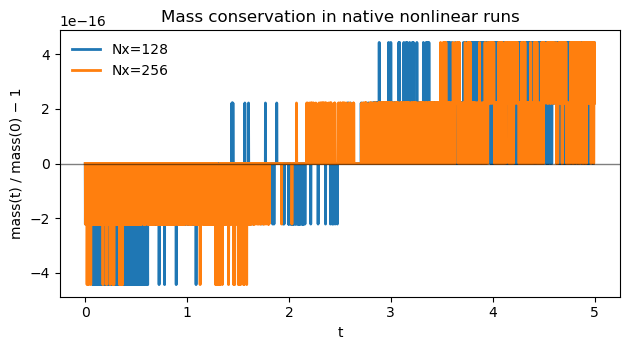

In [34]:
# %% mass conservation check: native nonlinear runs (Nx=128 and Nx=256)

# load metrics for both resolutions
tN_128, colsN_128 = load_metrics(RUN_N)
tN_256, colsN_256 = load_metrics(RUN_N_256)

mass_128 = colsN_128.get("mass", None)
mass_256 = colsN_256.get("mass", None)

if mass_128 is None or mass_256 is None:
    print("Mass not found in metrics; nothing to plot.")
else:
    mass_128 = np.asarray(mass_128, dtype=float)
    mass_256 = np.asarray(mass_256, dtype=float)

    # normalize by initial mass and subtract 1
    m0_128 = mass_128[0]
    m0_256 = mass_256[0]
    rel_128 = mass_128 / m0_128 - 1.0
    rel_256 = mass_256 / m0_256 - 1.0

    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    ax.plot(tN_128, rel_128, lw=2, label="Nx=128")
    ax.plot(tN_256, rel_256, lw=2, label="Nx=256")

    ax.axhline(0.0, color="k", lw=1, alpha=0.5)
    ax.set_xlabel("t")
    ax.set_ylabel("mass(t) / mass(0) − 1")
    ax.set_title("Mass conservation in native nonlinear runs")
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

### Noise-seeded run: Fourier spectrum evolution

For the noise-seeded native nonlinear run, the initial condition is a small
Gaussian random perturbation in Σ(x). The instability should pick out
preferred scales, so it is useful to look at the Fourier spectrum of Σ(x, t)
at different times.

Below we plot the physical cosine amplitudes \(A_k\) as a function of the
physical wavenumber \(k\) at three representative times: early, intermediate,
and late in the run. This shows how initially white-ish noise evolves into a
spectrum dominated by the most unstable band.

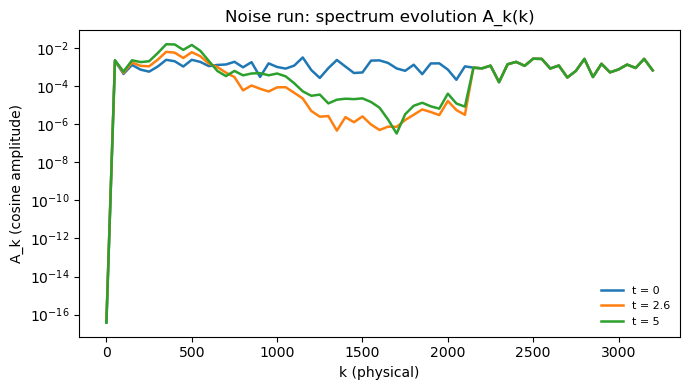

In [35]:
# %% Fourier spectrum evolution for noise-seeded run

RUN_NOISE = RUNS / "nl_noise_native"

Nx_noise, Lx_noise, files_noise, man_noise = load_nonlinear_run(RUN_NOISE)
T_noise, Sig_noise = load_nonlinear_Sigma_series(files_noise)   # shape: (Nt, Nx)

# physical grid and wavenumbers
x_noise = np.linspace(-0.5 * Lx_noise, 0.5 * Lx_noise, Nx_noise, endpoint=False)
ks_noise = 2.0 * np.pi * np.fft.rfftfreq(Nx_noise, d=Lx_noise / Nx_noise)

# choose a few representative times: early, middle, late
Nt_noise = len(T_noise)
idxs_spec = [
    0,
    Nt_noise // 2,
    Nt_noise - 1,
]

fig, ax = plt.subplots(figsize=(7.0, 4.0))

for idx in idxs_spec:
    S = Sig_noise[idx]
    s = S - S.mean()
    ak = np.fft.rfft(s)

    # physical cosine amplitudes A_k
    A_k = np.empty_like(ak, dtype=float)
    A_k[0] = np.abs(ak[0]) / Nx_noise
    A_k[1:] = 2.0 * np.abs(ak[1:]) / Nx_noise

    ax.plot(
        ks_noise,
        A_k,
        lw=1.8,
        label=f"t = {T_noise[idx]:.3g}",
    )

ax.set_xlabel("k (physical)")
ax.set_ylabel("A_k (cosine amplitude)")
ax.set_yscale("log")
ax.set_title("Noise run: spectrum evolution A_k(k)")
ax.legend(frameon=False, fontsize=8)
plt.tight_layout()
plt.show()

### Parameter precedence: defaults, experiment YAML, and CLI overrides

The IVP stack is designed so that parameters come from three layers:

1. `defaults.yaml` — global baseline values (e.g. typical `Nx`, `Lx`, physics knobs).
2. Experiment YAML, e.g. `unstable_baseline.yaml` — overrides the defaults for this setup.
3. CLI flags — override *runtime* knobs like `dt`, `stop_time`, `Nx`, seeds, etc.

The `Config` object is built by combining (1) and (2), while the actual run
metadata written to `run.json` reflects (3) as well. This small code block
shows:

- the `Nx` value baked into the config from the YAMLs (`Config.from_yaml`),
- and the effective `Nx` actually used in the Nx=128 and Nx=256 runs, read
  from their manifests.

In [36]:
# %% parameter precedence demo: defaults vs experiment vs CLI overrides

# Config built from defaults + experiment YAML
cfg_unstable = Config.from_yaml(EXP_UNSTABLE, DEFAULTS)
print("Config-level Nx (defaults + unstable_baseline):", cfg_unstable.Nx)

# Manifest info for specific runs (after CLI overrides)
man_N128 = load_manifest(RUN_N)
man_N256 = load_manifest(RUN_N_256)

print("Run Nx (nl_from_ic, native):    ", man_N128.get("Nx"))
print("Run Nx (nl_from_ic_Nx256, native):", man_N256.get("Nx"))

# For completeness, check dt and stop_time stored in the runs
print("Run dt (nl_from_ic):           ", man_N128.get("dt", None))
print("Run stop_time (nl_from_ic):    ", man_N128.get("stop_time", None))

Config-level Nx (defaults + unstable_baseline): 128
Run Nx (nl_from_ic, native):     128
Run Nx (nl_from_ic_Nx256, native): 256
Run dt (nl_from_ic):            None
Run stop_time (nl_from_ic):     None
